In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./data/raw/vgsales.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [4]:
df.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [5]:
df['sales_vs_genre_avg'] = df.groupby('Genre')['Global_Sales'].transform('mean').round(2)
df['above_genre_avg'] = df.Global_Sales > df.sales_vs_genre_avg

In [6]:
#Rank games within each genre
df['genre_rank'] = df.groupby('Genre')['Global_Sales'].rank(method='dense', ascending=False)
df['top_3_in genre'] = df['genre_rank'] <= 3
df['percentile_within_genre'] = df.groupby('Genre')['Global_Sales'].rank(pct=True)

In [7]:
platform_pub_sales = df.groupby(['Platform', 'Publisher'])['Global_Sales'].agg('sum').reset_index()
max_publisher = platform_pub_sales.loc[platform_pub_sales.groupby('Platform')['Global_Sales'].idxmax()]
dominant = max_publisher[['Platform', 'Publisher']]
df = df.merge(dominant, on='Platform', how='left', suffixes=('', '_dominant'))
df['is_dominant_publisher'] = df['Publisher'] == df['Publisher_dominant']

In [8]:
#Platform peak year - The year that platform had the highest total global sales
platform_yearly_total = df.groupby(['Platform', 'Year'])['Global_Sales'].sum().reset_index()
platform_peak_year = platform_yearly_total.loc[platform_yearly_total.groupby('Platform')['Global_Sales'].idxmax()][['Platform', 'Year']]

In [9]:
df = df.merge(platform_peak_year, on='Platform', how='left', suffixes=('', '_peak'))
df['is_peak_year_release'] = df['Year'] == df['Year_peak']

In [10]:
region_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
df['top_region'] = df[region_columns].idxmax(axis=1)
df['top_region_share'] = np.where(
  df.Global_Sales > 0,
  df[region_columns].max(axis=1) / df.Global_Sales,
  0
)

In [11]:
genre_distribution_per_area = df.groupby('Genre')['top_region'].value_counts(normalize=True)
genre_distribution_per_area = genre_distribution_per_area.unstack(fill_value=0);
genre_distribution_per_area

top_region,EU_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,
Action,0.157117,0.201146,0.634801,0.006936
Adventure,0.123639,0.521773,0.353810,0.000778
Fighting,0.051887,0.349057,0.594340,0.004717
Misc,0.106958,0.255319,0.627372,0.010351
Platform,0.088036,0.106095,0.801354,0.004515
Puzzle,0.164948,0.170103,0.664948,0.000000
Racing,0.203363,0.054444,0.737390,0.004804
Role-Playing,0.079301,0.513441,0.405242,0.002016
Shooter,0.187023,0.080916,0.731298,0.000763


In [12]:
sales_vs_genre_avg = df.groupby('Genre')['Global_Sales'].transform('mean')
df['above_genre_avg'] = df.Global_Sales > sales_vs_genre_avg
df[['Name', 'Genre', 'Global_Sales', 'above_genre_avg']].head(10)

,Name,Genre,Global_Sales,above_genre_avg
0,Wii Sports,Sports,82.74,True
1,Super Mario Bros.,Platform,40.24,True
2,Mario Kart Wii,Racing,35.82,True
3,Wii Sports Resort,Sports,33.00,True
4,Pokemon Red/Pokemon Blue,Role-Playing,31.37,True
5,Tetris,Puzzle,30.26,True
6,New Super Mario Bros.,Platform,30.01,True
7,Wii Play,Misc,29.02,True
8,New Super Mario Bros. Wii,Platform,28.62,True
9,Duck Hunt,Shooter,28.31,True


In [13]:
genre_weighted = df.groupby(['Genre', 'top_region'])['top_region_share'].sum()
genre_weighted=genre_weighted.unstack(fill_value=0)
genre_weighted = genre_weighted.div(genre_weighted.sum(axis=1), axis=0)
genre_weighted

top_region,EU_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,
Action,0.138991,0.259164,0.596175,0.005670
Adventure,0.106087,0.601768,0.291585,0.000559
Fighting,0.035560,0.431502,0.528918,0.004019
Misc,0.100600,0.310006,0.579701,0.009693
Platform,0.079778,0.130816,0.785356,0.004050
Puzzle,0.157270,0.189695,0.653035,0.000000
Racing,0.195276,0.070572,0.729112,0.005040
Role-Playing,0.073384,0.596578,0.328238,0.001801
Shooter,0.170371,0.108225,0.720790,0.000614


In [ ]:
# Weighted regional dominance for peak-year games
games_peak_year = df[df["is_peak_year_release"]]
weighted_peak_distribution = games_peak_year.groupby(["Genre", "top_region"])[
    "top_region_share"
].sum()
weighted_peak_distribution = weighted_peak_distribution.unstack(fill_value=0)
weighted_peak_distribution = weighted_peak_distribution.div(
    weighted_peak_distribution.sum(axis=1), axis=0
)
weighted_peak_distribution

top_region,EU_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,
Action,0.126963,0.179746,0.690930,0.002362
Adventure,0.126119,0.420966,0.452915,0.000000
Fighting,0.047584,0.387303,0.565113,0.000000
Misc,0.076596,0.303156,0.620249,0.000000
Platform,0.063824,0.153644,0.782531,0.000000
Puzzle,0.167853,0.172224,0.659923,0.000000
Racing,0.170122,0.082400,0.743997,0.003482
Role-Playing,0.047679,0.474667,0.477654,0.000000
Shooter,0.117229,0.112226,0.770545,0.000000


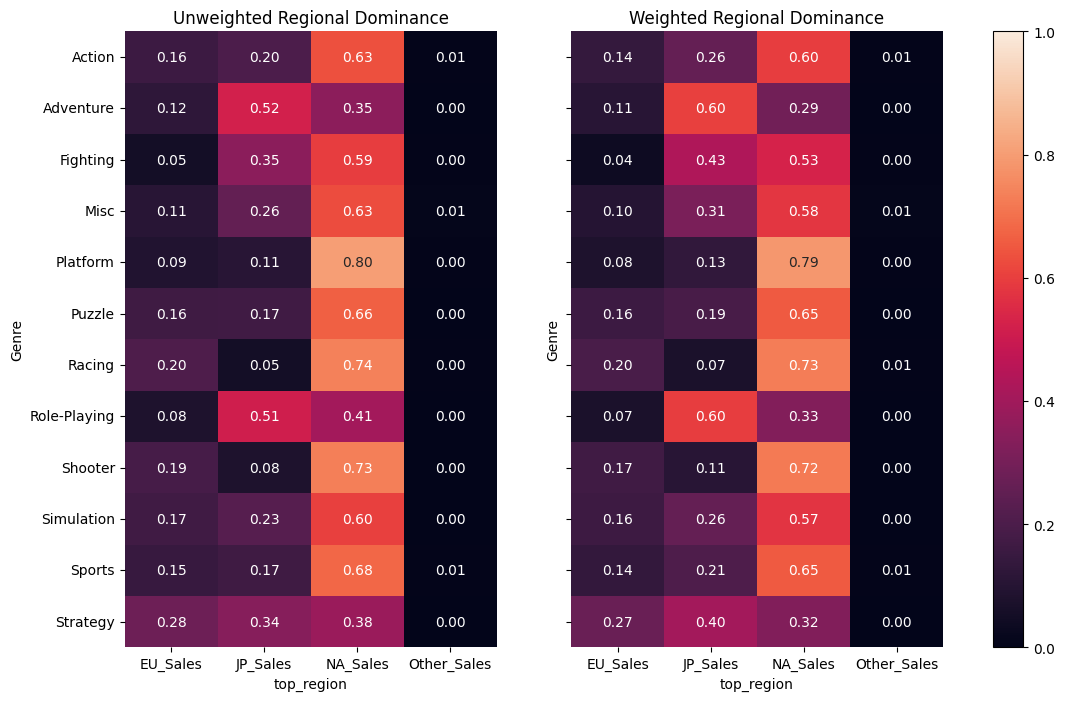

In [29]:
# Visualizations
# Genre regional dominance
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16,8))
hm1 = sns.heatmap(genre_distribution_per_area, annot=True, ax=ax1, fmt=".2f", vmin=0, vmax=1, cbar=False)
hm2 = sns.heatmap(genre_weighted, annot=True, ax=ax2, fmt='.2f', vmin=0, vmax=1, cbar=False)
fig.colorbar(hm1.collections[0], ax=[ax1, ax2], fraction=0.3, pad=0.04)
ax1.set_title('Unweighted Regional Dominance')
ax2.set_title('Weighted Regional Dominance')

plt.show()